# Walk Forward Analysis (Framework)


### Abstract:
Walk forward analysis is a method used to optimize trading strategies. It involves dividing historical data into segments and testing the strategy on each segment, then re-optimizing the parameters for the next segment. This ensures that the strategy adapts to changing market conditions and avoids overfitting.

However, TradingView does not provide this feature, so we need to manually create in-sample datasets (see prerequisites section below). After the manual process is complete, we can use Python to combine the Out of Sample periods (OOS) and visualize the performance of a strategy that had adopted different settings over historical time.

### Prerequisites:
Before running this script, you should have:
* A TradingView Premium account for accessing the "deep backtesting" feature and setting in-sample periods. This allows you to manually tested all combinations of strategy settings for in-sample periods.
* Exported the in-sample datasets as .csv files and use this script to parse the files containing "List_of_Trades".
* Knowledge of STATS101.
* Understanding of the purpose of walk forward optimizations.

### Example Strategy:

Here are the properties of the strategy used for illustrative purposes:
* Trend following, adds to existing winning position
* Risking USD1 per NASDAQ point movement (think of a "Half MNQ". You will multiply the results by 2 if you're trading MNQ, and 20 if it's NQ)
* Session: 0945-1545 EST

# Implementation

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import random

In [2]:
# Basic inputs
STARTING_CAPITAL = 10000
OPPORTUNITY_COST = 0.046 # Opportunity  cost of holding cash (ie earning 4.6%p.a with my idle cash on Interactive Brokers - not sponsored btw -)

## Combining: Out of Sample (OOS) periods

In [5]:
basepath = r"PineConnector\Backtests\Combined OOS_0004"
dfs = {} # Map of {directory name: dataframe}, ie {"20230630:df_oos"} representing the out of sample period ending June 30th 

# Recursively list all the files in basepath incluidng subdirectories
for entry in os.listdir(basepath):
    if os.path.isdir(os.path.join(basepath, entry)):
        for file in os.listdir(os.path.join(basepath, entry)):
            if file.endswith(".csv") and "_List_of_Trades_" in file:
                _full_path = os.path.join(basepath, entry, file)
                _dir = _full_path.split("\\")[-2]
                dfs[_dir] = pd.read_csv(_full_path)

In [6]:
# Concantenate the dataframes
df_oos_combined = pd.concat(dfs.values(), ignore_index=True)
df_oos_combined = df_oos_combined.astype({'Date/Time': 'datetime64[ns]'})
df_oos_combined.sort_values(by=['Date/Time'], inplace=True, ascending=True)

print("Combined OOS Dataframe (Before Cleaning):")
df_oos_combined.head(1)


Combined OOS Dataframe (Before Cleaning):


,Trade #,Type,Signal,Date/Time,Price USD,Contracts,Profit USD,Profit %,Cum. Profit USD,Cum. Profit %,Run-up USD,Run-up %,Drawdown USD,Drawdown %
89,1,Entry Long,init,2023-01-09 09:45:00,11198.6,1,54.2,0.48,54.2,0.54,107.5,0.96,3.3,0.03


In [7]:
irrelevant_columns = ['Profit %', 'Cum. Profit USD', 'Cum. Profit %', 'Run-up USD', 'Run-up %', 'Drawdown USD', 'Drawdown %', 'Trade #']

In [8]:
# Clean data
def clean_data(df_listoftrades): 
    # Remove unnecessary rows and columns
    df_listoftrades = df_listoftrades[df_listoftrades['Type'].str.contains("Exit", na=False)] # Becuase we only want the exit trades, and since entry rows also contain the profit value, including it will cause double count issues
    df_listoftrades = df_listoftrades.astype({'Date/Time': 'datetime64[ns]'})
    df_listoftrades = df_listoftrades.drop(columns=irrelevant_columns)

    # Sort by date
    df_listoftrades = df_listoftrades.sort_index(ascending=False)
    df_listoftrades = df_listoftrades.sort_values(by="Date/Time", ascending=True)
    df_listoftrades["Cum. Profit USD"] = df_listoftrades["Profit USD"].cumsum()

    # Equity balance starts at STARTING_CAPITAL
    df_listoftrades["Cum. Profit USD"] = df_listoftrades["Cum. Profit USD"] + STARTING_CAPITAL
    df_listoftrades["Log returns"] = np.log(df_listoftrades["Cum. Profit USD"] / df_listoftrades["Cum. Profit USD"].shift(1))
    df_listoftrades["Drawdown"] = df_listoftrades["Cum. Profit USD"].cummax() - df_listoftrades["Cum. Profit USD"]

    return df_listoftrades

df_listoftrades_clean = clean_data(df_oos_combined.copy())
print("Combined OOS Dataframe (After Cleaning):")
print("Shape of df_listoftrades_clean: ", df_listoftrades_clean.shape)
no_of_trades = df_listoftrades_clean.shape[0]
df_listoftrades_clean.head()

Combined OOS Dataframe (After Cleaning):
Shape of df_listoftrades_clean:  (480, 9)


,Type,Signal,Date/Time,Price USD,Contracts,Profit USD,Cum. Profit USD,Log returns,Drawdown
88,Exit Long,Reverse,2023-01-09 12:40:00,11252.8,1,54.2,10054.2,NaN,0.0
84,Exit Long,Reverse,2023-01-09 12:40:00,11252.8,1,-16.3,10037.9,-0.001623,16.3
82,Exit Long,Reverse,2023-01-09 12:40:00,11252.8,1,-44.9,9993.0,-0.004483,61.2
86,Exit Long,Reverse,2023-01-09 12:40:00,11252.8,1,8.4,10001.4,0.000840,52.8
80,Exit Short,Potential News,2023-01-09 13:55:00,11203.9,1,-3.9,9997.5,-0.000390,56.7


In [9]:
df_listoftrades_clean["Log returns"].describe()[:3]

count    479.000000
mean       0.000574
std        0.003593
Name: Log returns, dtype: float64

In [10]:
df_listoftrades_clean["Log returns"].kurtosis()

1.1811312473856992

## Robustness Analysis 

In [11]:
df_daily_pl = df_listoftrades_clean.groupby(df_listoftrades_clean["Date/Time"].dt.date)["Profit USD"].sum()
df_daily_pl = df_daily_pl.to_frame()
df_daily_pl["Cum. Profit USD"] = df_daily_pl["Profit USD"].cumsum()
df_daily_pl["Equity Balance"] = df_daily_pl["Cum. Profit USD"] + STARTING_CAPITAL
df_daily_pl["Log returns"] = np.log(df_daily_pl["Equity Balance"] / df_daily_pl["Equity Balance"].shift(1))
df_daily_pl["Drawdown"] = df_daily_pl["Cum. Profit USD"].cummax() - df_daily_pl["Cum. Profit USD"]
print(df_daily_pl.shape)
df_daily_pl.head()


(123, 5)


,Profit USD,Cum. Profit USD,Equity Balance,Log returns,Drawdown
Date/Time,,,,,
2023-01-09,10.4,10.4,10010.4,NaN,0.0
2023-01-10,-0.3,10.1,10010.1,-0.000030,0.3
2023-01-11,-58.6,-48.5,9951.5,-0.005871,58.9
2023-01-12,-107.3,-155.8,9844.2,-0.010841,166.2
2023-01-13,-37.3,-193.1,9806.9,-0.003796,203.5


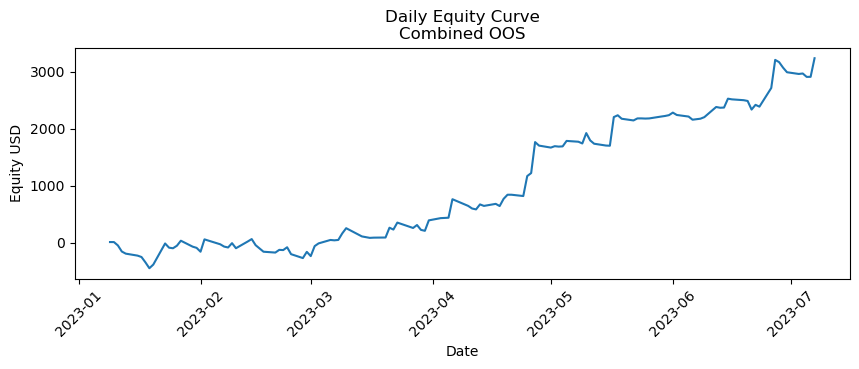

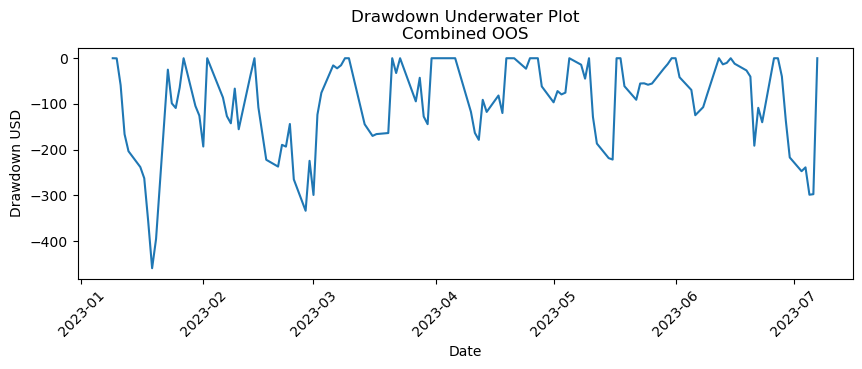

In [12]:

plt.figure(figsize=(10,3))
plt.plot(df_daily_pl["Cum. Profit USD"])
plt.title("Daily Equity Curve\nCombined OOS")
plt.xlabel("Date")
plt.ylabel("Equity USD")

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.figure(figsize=(10,3))
plt.plot(-df_daily_pl["Drawdown"])
plt.title("Drawdown Underwater Plot\nCombined OOS")
plt.xlabel("Date")
plt.ylabel("Drawdown USD")

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.show()

### Daily Stats

In [13]:
# Print stats
print("Starting capital:\t", STARTING_CAPITAL)
print("Max drawdown:\t\t", round(df_daily_pl["Drawdown"].max(),2))
print("No. of days (OOS):\t", df_daily_pl.shape[0])
df_daily_pl.describe().drop(columns=["Cum. Profit USD","Drawdown","Equity Balance"])[1:3]

Starting capital:	 10000
Max drawdown:		 459.5
No. of days (OOS):	 123


,Profit USD,Log returns
mean,26.334146,0.002291
std,126.131388,0.011255


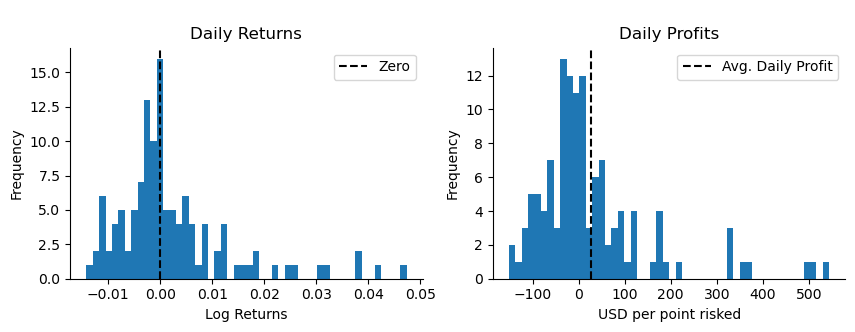

In [14]:
# Plot the distribution of daily returns and daily profits in subplot 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3)) 
n_bins=50

ax1.hist(df_daily_pl["Log returns"], bins=n_bins)
ax1.set_title("\nDaily Returns")
ax1.set_xlabel("Log Returns")
ax1.set_ylabel("Frequency")

ax1.axvline(x=0, color='k', linestyle='--').set_label("Zero")
ax1.legend()

ax2.hist(df_daily_pl["Profit USD"], bins=n_bins)
ax2.set_title("\nDaily Profits")
ax2.set_xlabel("USD per point risked")
ax2.set_ylabel("Frequency")

# Plot the average daily profit, horizontal line, on ax2 
ax2.axvline(x=df_daily_pl["Profit USD"].mean(), color='k', linestyle='--').set_label("Avg. Daily Profit")
ax2.legend()


# Remove spines
ax1.spines['right'].set_visible(False), ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False), ax2.spines['top'].set_visible(False)
plt.show()


In [15]:
df_daily_pl["Log returns"].kurtosis()

3.8593384643726427

### Monte Carlo Simulations

In [16]:
# Monte carlo simulations
def monte_carlo_equity_curve(df_listoftrades, n_simulations=1000, n_trades=100):
    _equity_curves = []
    for _ in range(n_simulations):
        _equity_curve = [0]
        for _ in range(n_trades):
            _equity_curve.append(_equity_curve[-1] + random.choice(df_listoftrades["Profit USD"].values))
        _equity_curves.append(_equity_curve)
    return _equity_curves

_n_forecast = 252
daily_simulations = monte_carlo_equity_curve(df_daily_pl, n_simulations=10000, n_trades=_n_forecast)
daily_simulations = np.array(daily_simulations)
print("Shape of daily_simulations: ", daily_simulations.shape)


Shape of daily_simulations:  (10000, 253)


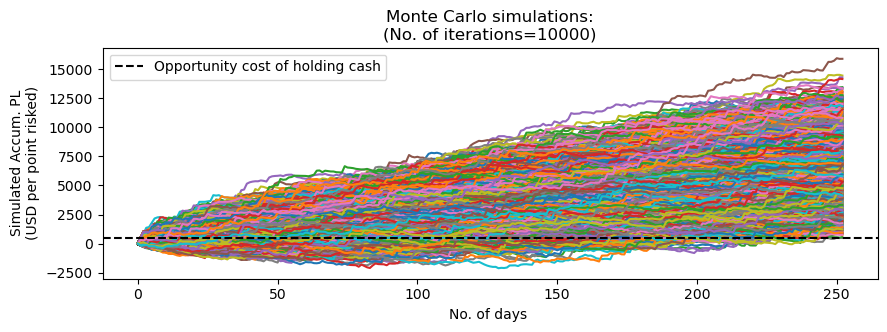

In [17]:
# Plot the MCS
plt.figure(figsize=(10,3))
plt.plot(daily_simulations.T)
plt.title("Monte Carlo simulations:\n(No. of iterations={})".format(daily_simulations.shape[0]))
plt.xlabel("No. of days ")
plt.ylabel("Simulated Accum. PL\n(USD per point risked)")

# Plot horizontal line; depicting opportunity cost of holding cash
plt.axhline(STARTING_CAPITAL*OPPORTUNITY_COST, color='black', linestyle='--').set_label("Opportunity cost of holding cash")
plt.legend()

plt.show()

**Acceptabillity of strategy:** If the simulated cases are mostly above the dotted horizontal line (representing the opportunity cost of holding cash) at time+252

# Summary
### Recap: Daily Stats
These stats can be used for comparison against competing strategies.

In [18]:
# Recap of Daily stats 
print("Starting capital:\t", STARTING_CAPITAL)
print("Max drawdown:\t\t", round(df_daily_pl["Drawdown"].max(),2))
print("No. of days (OOS):\t", df_daily_pl.shape[0])
df_daily_pl.describe().drop(columns=["Cum. Profit USD","Drawdown","Equity Balance"])[1:3]

Starting capital:	 10000
Max drawdown:		 459.5
No. of days (OOS):	 123


,Profit USD,Log returns
mean,26.334146,0.002291
std,126.131388,0.011255
